# Project 2: LSTM

### Chris Hanes and Tyler Schoenrock 

#### CSE 6240

In [ ]:
#Link to download English Text
https://raw.githubusercontent.com/GT-CSE6240/proj2/master/data/eng.txt

#Link to download French Text
https://raw.githubusercontent.com/GT-CSE6240/proj2/master/data/frn.txt

#Tutorial link
http://cloudmark.github.io/Language-Detection-Implemenation/

##### Tasks for Part 1

● Split both files into 80/20 learning/holdout sets
    
    ○ Use example code below to split text and convert to lower case

● Copy example code below  LSTM on both files
    
    ○ Size is 128
    ○ nepochs=5
    ○ An example line from your script might be:
      model.fit(X_train_eng, y_train_eng, batch_size=128, nb_epoch=5)
      
● Create the 200 5-char substrings for the testing set (100 eng and 100 fr)
    
    ○ Set y_test as 1 for english and 0 for french
    
● Calculate y_hat from testing sets: For each 5-char substring,
    
    ○ probability of english:
      1. Calculate probability of 1st letter given start
      2. Calculate probability of 2nd letter given start, 1st
      3. Calculate probability of 3nd letter given start, 1st, 2nd
      4. Calculate probability of 4th letter given start, 1st, 2nd, 3rd
      5. Calculate probability of 5th letter given start, 1st, 2nd, 3rd, 4th
      6. Take log() of each probability and add together
      
    ○ Repeat for french probability
    ○ Divide log_likelihood_english/log_likelihood_french    

● Use sklearn to compute ROC curve with y_hat
    
    ○ plot using semilogx and print the AUC-ROC on the plot

#####  Questions to Answer for Part 1

○ Is this model good?

○ What are at least three alternatives to language detection that you can think   of or find on the internet? What are the pros and cons of each approach?
    
○ Briefly describe at least 5 ways that you can improve this model, and what you
  think the value and predicted result of each approach would be? Example:
  “could use GPUs for training -> faster to get datasets; no change in efficacy”

###### Note to Chris on Extra Credit

I'm thinking an easy extra credit idea he mentioned in class we could do 
would look at just using the datasets on the tutorial site for other languages

We could look at the error between similar languages together
versus classifying very dissimilar languages. i.e. What's the error
when we classify between portuguese and spanish vs. portuguese and russian.

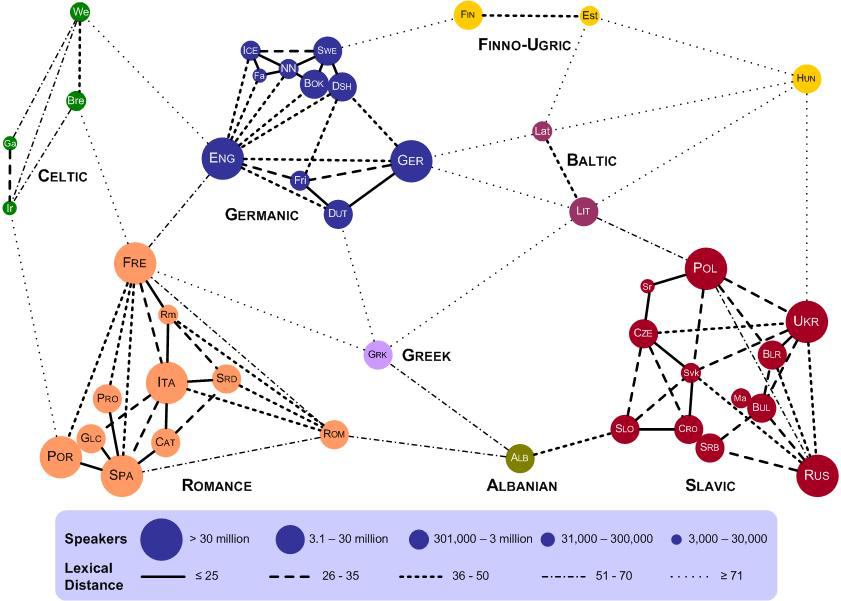

In [15]:
#Source: https://elms.wordpress.com/2008/03/04/lexical-distance-among-languages-of-europe/

###### Example code from instructions for LSTM text generation for Reference

In [ ]:
'''Example script to generate text from Nietzsche's writings.
At least 20 epochs are required before the generated text
starts sounding coherent.
It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.
If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.
'''

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys

path = get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y,
              batch_size=128,
              epochs=1)

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()